# Glaucoma Detection from Clinical Notes - Google Colab

**Instructions:**
1. Upload this notebook to Google Colab
2. Enable GPU: Runtime > Change runtime type > GPU
3. Upload `clinical_notes.csv` when prompted
4. Run all cells

**Note:** You can also clone your GitHub repo instead of uploading files

## Setup - Install Dependencies

In [4]:
# Install required packages (Colab already has most of these)
!pip install -q tensorflow pandas numpy matplotlib seaborn scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Upload Data

**Option 1:** Upload clinical_notes.csv manually

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Option 2:** Clone from GitHub (if you've uploaded there)

In [ ]:
# Uncomment and modify with your GitHub URL
# !git clone https://github.com/yourusername/your-repo.git
# %cd your-repo

## Copy All Code from Your Local Files

Below cells contain all the code from your project files

In [5]:
# PREPROCESSING CODE
import re
import pickle

class ClinicalNotesPreprocessor:
    def __init__(self, max_words=10000, max_len=500):
        self.max_words = max_words
        self.max_len = max_len
        self.tokenizer = None

    def clean_text(self, text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'\bdate_time\b', 'datetoken', text)
        text = re.sub(r'\bperson\b', 'persontoken', text)
        text = re.sub(r'\blocation\b', 'locationtoken', text)
        text = re.sub(r'\bphone_number\b', 'phonetoken', text)
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^a-z0-9\s\./\-]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def prepare_data(self, df):
        print("Cleaning clinical notes...")
        df['cleaned_note'] = df['note'].apply(self.clean_text)
        df['label'] = (df['glaucoma'] == 'yes').astype(int)
        df_filtered = df[df['race'].isin(['asian', 'black', 'white'])].copy()
        print(f"Dataset size: {len(df_filtered)}")
        print(f"Glaucoma positive: {df_filtered['label'].sum()}")
        return df_filtered

    def tokenize_and_pad(self, train_texts, val_texts, test_texts):
        print("Tokenizing...")
        self.tokenizer = Tokenizer(num_words=self.max_words, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(train_texts)

        train_seq = self.tokenizer.texts_to_sequences(train_texts)
        val_seq = self.tokenizer.texts_to_sequences(val_texts)
        test_seq = self.tokenizer.texts_to_sequences(test_texts)

        train_padded = pad_sequences(train_seq, maxlen=self.max_len, padding='post')
        val_padded = pad_sequences(val_seq, maxlen=self.max_len, padding='post')
        test_padded = pad_sequences(test_seq, maxlen=self.max_len, padding='post')

        print(f"Vocab size: {len(self.tokenizer.word_index)}")
        return train_padded, val_padded, test_padded

In [6]:
# MODEL IMPLEMENTATIONS

def build_lstm_model(vocab_size, max_len):
    model = models.Sequential([
        layers.Embedding(vocab_size, 128, input_length=max_len),
        layers.SpatialDropout1D(0.2),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ], name='LSTM')
    return model

def build_gru_model(vocab_size, max_len):
    model = models.Sequential([
        layers.Embedding(vocab_size, 128, input_length=max_len),
        layers.SpatialDropout1D(0.2),
        layers.Bidirectional(layers.GRU(128, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(layers.GRU(64)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ], name='GRU')
    return model

def build_cnn_model(vocab_size, max_len):
    model = models.Sequential([
        layers.Embedding(vocab_size, 128, input_length=max_len),
        layers.SpatialDropout1D(0.2),
        layers.Conv1D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.5),
        layers.Conv1D(128, 5, padding='same', activation='relu'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.5),
        layers.Conv1D(64, 3, padding='same', activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ], name='CNN')
    return model

def build_transformer_model(vocab_size, max_len):
    inputs = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, 128)(inputs)

    positions = tf.range(start=0, limit=max_len, delta=1)
    pos_emb = layers.Embedding(max_len, 128)(positions)
    x = x + pos_emb

    # Transformer block
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.5)(x, x)
    x1 = layers.Add()([x, attn])
    x1 = layers.LayerNormalization()(x1)

    ffn = layers.Dense(256, activation='relu')(x1)
    ffn = layers.Dropout(0.5)(ffn)
    ffn = layers.Dense(128)(ffn)
    x = layers.Add()([x1, ffn])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=inputs, outputs=outputs, name='Transformer')

## Load and Prepare Data

In [7]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/csce566/clinical_notes.csv')
print(f"Loaded {len(df)} samples")

# Prepare data
preprocessor = ClinicalNotesPreprocessor(max_words=10000, max_len=500)
df = preprocessor.prepare_data(df)

# Split data
train_val_df = df[df['use'] == 'training']
test_df = df[df['use'] == 'test']

train_df, val_df = train_test_split(train_val_df, test_size=0.15,
                                     random_state=42, stratify=train_val_df['label'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Tokenize
X_train, X_val, X_test = preprocessor.tokenize_and_pad(
    train_df['cleaned_note'].values,
    val_df['cleaned_note'].values,
    test_df['cleaned_note'].values
)

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values
test_race = test_df['race'].values

vocab_size = min(10000, len(preprocessor.tokenizer.word_index) + 1)
print(f"Vocab size: {vocab_size}")

Loaded 10000 samples
Cleaning clinical notes...
Dataset size: 10000
Glaucoma positive: 5048
Train: 5950, Val: 1050, Test: 2000
Tokenizing...
Vocab size: 15172
Vocab size: 10000


## Train Models

In [8]:
# Training configuration
EPOCHS = 30  # Reduced for Colab
BATCH_SIZE = 32

models_dict = {
    'LSTM': build_lstm_model(vocab_size, 500),
    'GRU': build_gru_model(vocab_size, 500),
    'CNN': build_cnn_model(vocab_size, 500),
    'Transformer': build_transformer_model(vocab_size, 500)
}

results = {}

for name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print('='*60)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    callbacks = [
        EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    y_pred = model.predict(X_test).flatten()
    auc = roc_auc_score(y_test, y_pred)

    results[name] = {
        'model': model,
        'history': history,
        'predictions': y_pred,
        'auc': auc
    }

    print(f"\n{name} Test AUC: {auc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training LSTM
Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.5682 - auc: 0.5799 - loss: 0.6757 - val_accuracy: 0.6686 - val_auc: 0.7748 - val_loss: 0.6023 - learning_rate: 0.0010
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.7594 - auc: 0.8280 - loss: 0.5125 - val_accuracy: 0.7124 - val_auc: 0.8081 - val_loss: 0.5389 - learning_rate: 0.0010
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.8512 - auc: 0.9133 - loss: 0.3773 - val_accuracy: 0.7390 - val_auc: 0.8192 - val_loss: 0.5584 - learning_rate: 0.0010
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.8914 - auc: 0.9508 - loss: 0.2851 - val_accuracy: 0.7248 - val_auc: 0.8126 - val_loss: 0.6457 - learning_rate: 0.0010
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9149 - auc: 0.9715 - loss: 0.2158 - val_accuracy: 0.7019 - val_auc: 0.7754 - val_loss: 0.7352 - learning_rate: 0.0010
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step

## Evaluate with Fairness Metrics

In [9]:
# Calculate race-specific metrics
print("\nRace-Specific Performance:\n")

for name, result in results.items():
    print(f"\n{name}:")
    y_pred = result['predictions']

    for race in ['asian', 'black', 'white']:
        mask = test_race == race
        if mask.sum() > 0:
            race_auc = roc_auc_score(y_test[mask], y_pred[mask])
            print(f"  {race.capitalize()}: AUC = {race_auc:.4f} (n={mask.sum()})")


Race-Specific Performance:


LSTM:
  Asian: AUC = 0.8372 (n=158)
  Black: AUC = 0.8279 (n=305)
  White: AUC = 0.8094 (n=1537)

GRU:
  Asian: AUC = 0.8446 (n=158)
  Black: AUC = 0.8696 (n=305)
  White: AUC = 0.8220 (n=1537)

CNN:
  Asian: AUC = 0.9309 (n=158)
  Black: AUC = 0.8982 (n=305)
  White: AUC = 0.8550 (n=1537)

Transformer:
  Asian: AUC = 0.5063 (n=158)
  Black: AUC = 0.4929 (n=305)
  White: AUC = 0.5000 (n=1537)


## Visualize Results

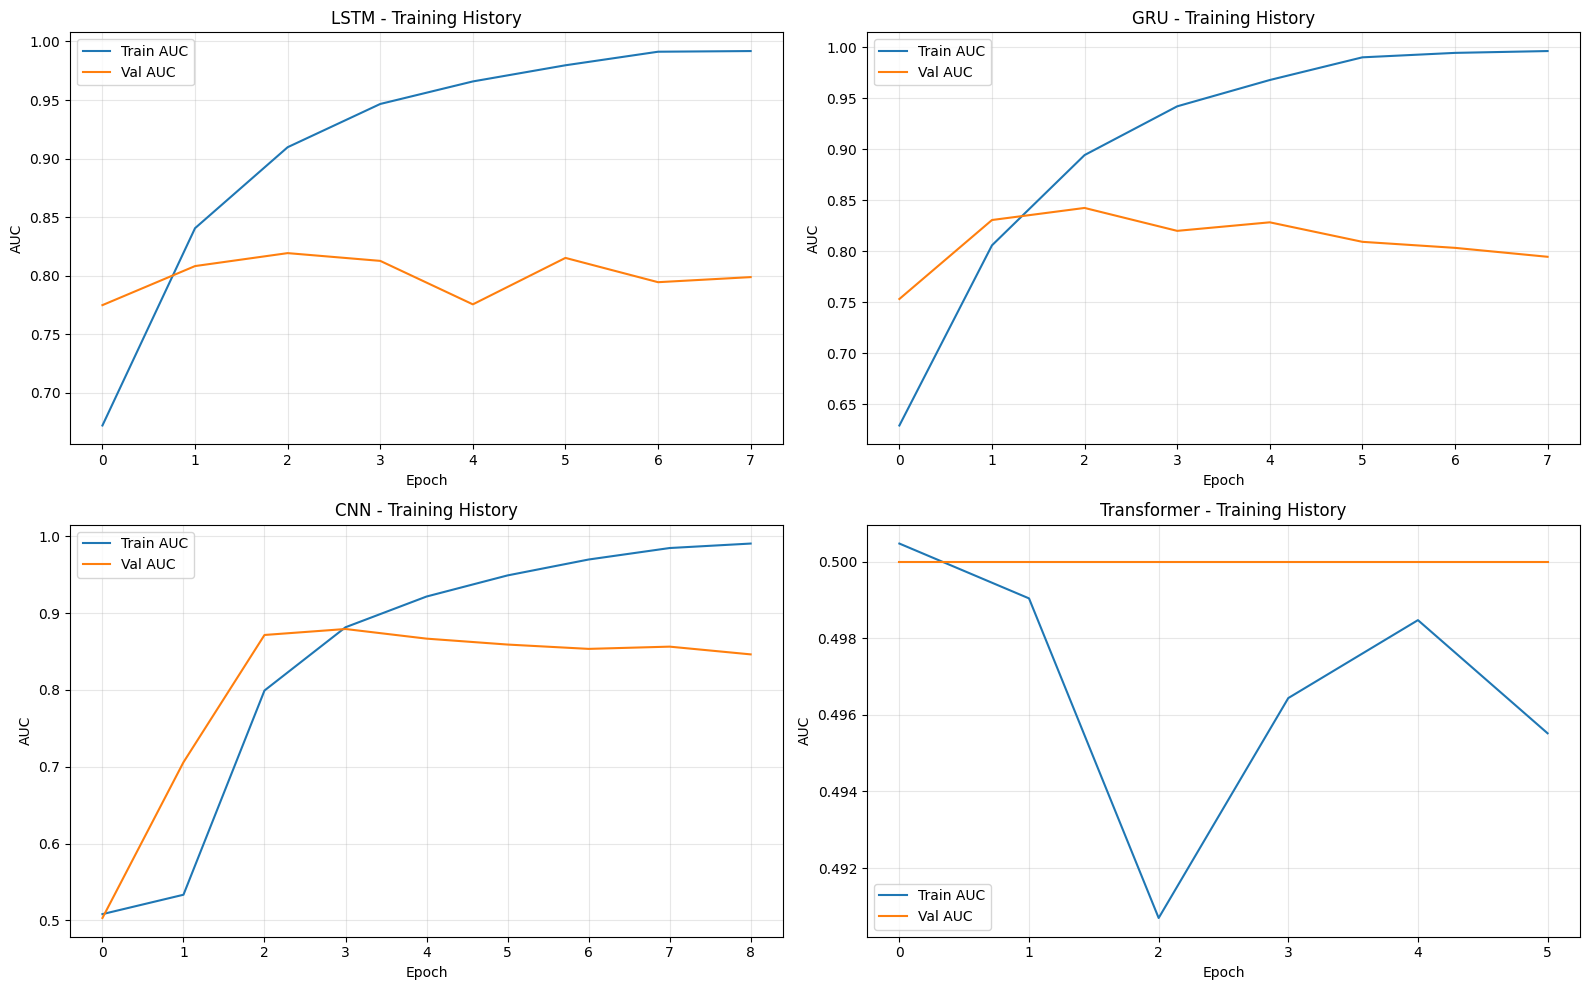

In [10]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx // 2, idx % 2]
    history = result['history'].history

    ax.plot(history['auc'], label='Train AUC')
    ax.plot(history['val_auc'], label='Val AUC')
    ax.set_title(f'{name} - Training History')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Download Results

In [4]:
# Save results to CSV
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC': [r['auc'] for r in results.values()]
})

results_df.to_csv('model_results.csv', index=False)
print(results_df)

# Download
files.download('model_results.csv')

NameError: name 'pd' is not defined

In [3]:
from google.colab import files